In [76]:
### Decide about the features to take according to the submission file

import pandas as pd
import numpy as np
data1 = pd.read_table('submission.txt')

In [77]:
len(data1)

82909

In [78]:
import time
data1['time'] = data1['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
data1['day_week'] = data1['time'].apply(lambda x: time.strftime("%w", x))
data1['month'] = data1['time'].apply(lambda x: time.strftime("%m", x))

In [79]:
### New features: dummies for the day of the week, ASS_ASSIGNMENT, months

data1 = pd.concat((data1, pd.get_dummies(data1['day_week'])),axis=1)
data1 = pd.concat((data1, pd.get_dummies(data1['ASS_ASSIGNMENT'])),axis=1)
data1 = pd.concat((data1, pd.get_dummies(data1['month'])),axis=1)


In [80]:
### New feature: hours since the start of the day

data1['time_absolut'] = data1['time'].apply(time.mktime) ### date scince epoch
data1['hours'] = data1['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [81]:
data1['year_week'] = data1['time'].apply(lambda x: time.strftime("%Y+%U", x))

In [82]:
time.gmtime(data1['time_absolut'].max())

time.struct_time(tm_year=2013, tm_mon=12, tm_mday=28, tm_hour=22, tm_min=30, tm_sec=0, tm_wday=5, tm_yday=362, tm_isdst=0)

In [83]:
time.gmtime(data1['time_absolut'].min())

time.struct_time(tm_year=2012, tm_mon=12, tm_mday=27, tm_hour=23, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=362, tm_isdst=0)

In [84]:
indexes = np.concatenate((data1.day_week.unique(), data1.ASS_ASSIGNMENT.unique()))
indexes = np.concatenate((indexes, data1.month.unique()))
indexes = np.concatenate((indexes, data1.ASS_ASSIGNMENT.unique()))
indexes = np.concatenate((indexes, ['hours']))
indexes = np.concatenate((indexes, ['time_absolut']))
#indexes = np.concatenate((indexes, ['mean_week_ASS']))
indexes = np.concatenate((indexes, ['mean_calls_time_ASS','mean_calls_time']))


In [85]:
len(data1)

82909

In [86]:
indexes

array(['5', '6', '0', '1', '2', '3', '4', 'CMS', 'Crises', 'Domicile',
       'Gestion', 'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie', 'Tech. Total',
       'Mécanicien', 'CAT', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires', '12', '01', '02', '03', '04', '05', '06',
       '07', '08', '09', '10', '11', 'CMS', 'Crises', 'Domicile',
       'Gestion', 'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie', 'Tech. Total',
       'Mécanicien', 'CAT', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires', 'hours', 'time_absolut',
       'mean_calls_time_AS

In [87]:
### Test data processing

M=100000
#data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'], nrows=M)
data = pd.read_csv('train_2011_2012_2013.csv',delimiter=';',usecols=['DATE','ASS_ASSIGNMENT','CSPL_RECEIVED_CALLS'], na_values=-1)

In [88]:
d = pd.DataFrame(data.groupby(['DATE', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].sum())
d.reset_index(level=0, inplace=True)
d.reset_index(level=0, inplace=True)
data = d

In [89]:
#data = data[data['CSPL_RECEIVED_CALLS']>0]

In [90]:
data['time'] = data['DATE'].apply(lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S.000'))
data['day_week'] = data['time'].apply(lambda x: time.strftime("%w", x))
data['month'] = data['time'].apply(lambda x: time.strftime("%m", x))

In [16]:
#data['ASS_ASSIGNMENT'].value_counts()

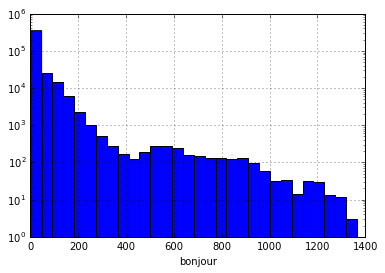

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.yscale('log')
data['CSPL_RECEIVED_CALLS'].hist(bins=30)
plt.xlabel('bonjour')

In [91]:
### New features: dummies for the day of the week, ASS_ASSIGNMENT, months

data = pd.concat((data, pd.get_dummies(data['day_week'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['ASS_ASSIGNMENT'])),axis=1)
data = pd.concat((data, pd.get_dummies(data['month'])),axis=1)

In [92]:
### New feature: hours since the start of the day
data['hours'] = data['time'].apply(lambda x: float(time.strftime("%H", x))+np.sign(float(time.strftime("%M", x)))*0.5)

In [93]:
### date scince epoch
data['time_absolut'] = data['time'].apply(time.mktime)

In [94]:
data['year_week'] = data['time'].apply(lambda x: time.strftime("%Y+%U", x))

In [22]:
time.gmtime(data['time_absolut'].max())

time.struct_time(tm_year=2013, tm_mon=12, tm_mday=31, tm_hour=22, tm_min=30, tm_sec=0, tm_wday=1, tm_yday=365, tm_isdst=0)

In [23]:
time.gmtime(data['time_absolut'].min())

time.struct_time(tm_year=2010, tm_mon=12, tm_mday=31, tm_hour=23, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=365, tm_isdst=0)

In [24]:
### New feature: average over the concrete week for the specific 'ASS_ASSIGNMENT'

d3 = pd.DataFrame(data.groupby(['year_week', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].mean())

mean_week_ASS_res = d3

d3.reset_index(level=0, inplace=True)
d3.reset_index(level=0, inplace=True)
data = d3.merge(data,on=['year_week','ASS_ASSIGNMENT'])
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_x' : 'mean_week_ASS'})
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_y' : 'CSPL_RECEIVED_CALLS'})

In [95]:
### New feature: average over all the dates for the specific category and time

d1 = pd.DataFrame(data.groupby(['hours', 'ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].mean())

mean_calls_time_ASS_res = d1

d1.reset_index(level=0, inplace=True)
d1.reset_index(level=0, inplace=True)
data = d1.merge(data,on=['hours','ASS_ASSIGNMENT'])
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_x' : 'mean_calls_time_ASS'})
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_y' : 'CSPL_RECEIVED_CALLS'})

In [96]:
### New feature: average over all the dates for the specific time

d2 = pd.DataFrame(data.groupby(['hours'])['CSPL_RECEIVED_CALLS'].mean())

mean_calls_time_res = d2

d2.reset_index(level=0, inplace=True)
d2.reset_index(level=0, inplace=True)
data = d2.merge(data,on=['hours'])
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_x' : 'mean_calls_time'})
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_y' : 'CSPL_RECEIVED_CALLS'})

In [100]:
### New feature: average over all 'ASS_ASSIGNMENT' for the specific time

d5 = pd.DataFrame(data.groupby(['ASS_ASSIGNMENT'])['CSPL_RECEIVED_CALLS'].mean())

mean_calls_ASS = d5

d5.reset_index(level=0, inplace=True)
d5.reset_index(level=0, inplace=True)
data = d5.merge(data,on=['ASS_ASSIGNMENT'])
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_x' : 'mean_calls_ASS'})
data = data.rename(index=str,  columns={'CSPL_RECEIVED_CALLS_y' : 'CSPL_RECEIVED_CALLS'})

In [101]:
data['mean_calls_ASS']

0          51.027950
1          51.027950
2          51.027950
3          51.027950
4          51.027950
5          51.027950
6          51.027950
7          51.027950
8          51.027950
9          51.027950
10         51.027950
11         51.027950
12         51.027950
13         51.027950
14         51.027950
15         51.027950
16         51.027950
17         51.027950
18         51.027950
19         51.027950
20         51.027950
21         51.027950
22         51.027950
23         51.027950
24         51.027950
25         51.027950
26         51.027950
27         51.027950
28         51.027950
29         51.027950
             ...    
1030799    71.389055
1030800    71.389055
1030801    71.389055
1030802    71.389055
1030803    71.389055
1030804    71.389055
1030805    71.389055
1030806    71.389055
1030807    71.389055
1030808    71.389055
1030809    71.389055
1030810    71.389055
1030811    71.389055
1030812    71.389055
1030813    71.389055
1030814    71.389055
1030815    71

In [102]:
indexes

array(['5', '6', '0', '1', '2', '3', '4', 'CMS', 'Crises', 'Domicile',
       'Gestion', 'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie', 'Tech. Total',
       'Mécanicien', 'CAT', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires', '12', '01', '02', '03', '04', '05', '06',
       '07', '08', '09', '10', '11', 'CMS', 'Crises', 'Domicile',
       'Gestion', 'Gestion - Accueil Telephonique', 'Gestion Assurances',
       'Gestion Relation Clienteles', 'Gestion Renault', 'Japon',
       'Médical', 'Nuit', 'RENAULT', 'Regulation Medicale', 'SAP',
       'Services', 'Tech. Axa', 'Tech. Inter', 'Téléphonie', 'Tech. Total',
       'Mécanicien', 'CAT', 'Manager', 'Gestion Clients', 'Gestion DZ',
       'RTC', 'Prestataires', 'hours', 'time_absolut',
       'mean_calls_time_AS

In [103]:
indexes = np.concatenate((indexes, ['mean_calls_ASS']))

In [104]:
### Algorithmic part

from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.cross_validation import train_test_split

X = data[indexes]

In [105]:
Y = data['CSPL_RECEIVED_CALLS']
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [106]:
model = rf()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [107]:
pred = np.round(pred)

In [116]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2_score(y_test, pred)
#mean_squared_error(y_test, pred)

ValueError: Found arrays with inconsistent numbers of samples: [ 82909 257708]

In [33]:
#y_test

In [109]:
data1 = data1.merge(mean_calls_time_res,on=['hours'],how ='left',sort=False)
data1['mean_calls_time']=data1['CSPL_RECEIVED_CALLS']

In [110]:
data1 = data1.merge(mean_calls_time_ASS_res,on=['hours','ASS_ASSIGNMENT'], how ='left', sort=False)
data1['mean_calls_time_ASS'] = data1['CSPL_RECEIVED_CALLS_y']

In [111]:
data1 = data1.merge(mean_calls_ASS,on=['ASS_ASSIGNMENT'],how ='left',sort=False)
data1['mean_calls_ASS']=data1['CSPL_RECEIVED_CALLS']

In [112]:
X = data1[indexes]

In [113]:
pred = np.round(model.predict(X)).astype(int)

In [114]:
d = pd.DataFrame(pred, columns=['prediction'])
data1['prediction'] = d['prediction']

In [115]:
import csv
base_filename = 'submission1.csv'
data1[['prediction']].to_csv(base_filename, sep=' ', index=False, quoting=None)